# Daniel Bain
# Udacity Deep Reinforcement Learning Course
# Project #1: Navigation

---

In this notebook, I am utilizing a Deep Q Network ("DQN") to apply Reinforcement Learning  to navigate a Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

To keep things simple and easier to follow along, all code except for the game library engine is in this notebook.

## Find the Yellow Bananas

For this assignment, we have been tasked with writing a Deep Q Network to learn to play a 3-D navigation game to run over as many yellow bananas as possible while avoiding blue bananas.   This Deep Q Network is generalized and can be applied to learn to play other games or solve other tasks.

The banana game simulation contains a single agent that navigates the environment. At each time step, it has four actions at its disposal:

- `0` - walk forward
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction. 

A player earns a reward of `+1` for "collecting" (running into) each yellow banana and `-1` for collecting each blue banana.

The assignment is to set up a value network to train to play the game and successfully get an average of 13 points over 100 games.


## Deep Q Network (DQN)

Deep Mind, now a subsidiary of Google, first demonstrated a Deep Q Network to play Atari Games at the end of 2014 (Playing Atari with Deep Reinforcement Learning, Minh et al.) and in more detail in a Nature Article published in 2015.  This was a major breakthrough because a single network was able to learn to play multiple games without modification and was able to play at human champion levels.

A Q function is a state-action value function that specifies how good an action ("a") is in the state ("s"). The value of all possible actions in each state is stored in a table called a Q table.  The Q table is used to choose the optimal action (that with the maximum value) in a state.

A deep Q Network uses a deep neural network to approximate the value function.

Unlike in the Deep Mind papers, where they used screen shots of games to train the network, for the first phase of this assignment have been asked to use the above described 37 dimension state space as inputs to train our network.  This lower dimensioned state space is much simpler and faster to train and does not require any preprocessing (outputted values already appear to be normalized for easy training with a neural network).

To complete this assignment, I have modified code from a vanilla DQN used to train playing a Lunar Lander game that was presented earlier in the Udacity course.  Then I have implemented a couple simple improvements by adding a Double DQN and a Dueling DQN, which are described in more detail below.


## Improvements: Double DQN & Dueling DQN

Since Deep Mind published its Atari papers in 2014 and 2015 there have been a succession of improvements to the vanilla DQN model to help improve learning and reach convergence faster.

In this notebook, I have attempted to implement two of these improvements: (i) Double DQN; and (ii) Dueling DQN.  Honestly, I chose these two because they were fairly straight forward to implement.   

### (i) Double DQN

Conventional Q-learning suffers from overestimation bias in the maximization step. Double Q-learning addresses this overestimation by decoupling, in the maximization performed for the bootstrap target, the selection of the action from its evaluation. (van Hasselt 2010)
This change was shown to reduce harmful overestimations that were present for DQN, thereby improving performance.

### (ii) Dueling DQN

Dueling DQN's were proposed in a 2016 Deep Mind paper (arXiv:1511.06581v3 [cs.LG] 5 Apr 2016).  The dueling network represents two separate estimators: one for the state value function and one for the state-dependent action advantage function. The researchers at Deep Mind showed that by doing so, learning is generalized across actions without imposing any change to the underlying reinforcement learning algorithm. They also showed better learning and faster convergence.

The figure below from the Deep Mind paper illustrates a basic DQN (top) and a dueling architecture (bottom):

![image.png](attachment:image.png)


### Other Improvements to DQN

Deep Mind wrote another paper in October, 2017 where they showed that combining 6 improvement techniques to the original DQN model (https://arxiv.org/pdf/1710.02298.pdf) provided for faster training/convergence as well as for higher performance. In addition to the 2 techniques mentioned above and implemented herein, Deep Mind also included (1) Prioritized DQN (e.g., prioritize  samples from the Experience Replay Buffer where there is more to learn), (2) Multi-Step Learning (rather than simply looking ahead one step, forward view multi-step targets are used), (3) Distributional RL (learn to approximate distribution of returns rather than expected return), and (4) Noisy Nets (noisy linear layer that combines a deterministic and noisy stream).  

Obviously, if you are coding a DQN, you'd probably start with code that already implements all 6 of the "rainbow" of techniques...



## 1.  Set Up

First step is to import needed libraries, start up the "Unity" (banana game playing) environment, and determine the number of actions and size of the state space.  

I am running this code on my local Mac and therefore the banana game Unity library is located locally on my Mac.  

While I have included the Mac version of the Unity banana environment that I ran on my local machine on this Github repo, if you want to run this code on your local machine, Udacity provides the following links to download the banana environment (obviously, select the environment that matches your operating system):

- Linux: https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip
- Mac OSX: https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana.app.zip
- Windows (32-bit): https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86.zip
- Windows (64-bit): https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86_64.zip

Also the filepath in the coe below should be changed depending on the location of the Unity environment:

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [1]:
# import needed libraries

from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline


# Start the environment
env = UnityEnvironment(file_name="/Users/danielbain/deep-reinforcement-learning/Udacity_P1_Navigation/Banana.app")

# get the default brain (e.g., responsible for deciding the actions of associated agents)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# determine number of actions & size of state
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

# use GPU if available, otherwise, use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 2.  Deep Learning Q Network Class

Next step is to set up the Deep Learning Q Network class.  Here I'm using a simple two layer network in Pytorch with 64 nodes at each layer.  I've added 20% dropout at each layer to reduce over-fitting and, at least for a simple DQN, note improved performance with the dropout layers.  

The Deep Q network takes the "state size" (e.g., parameters describing what's going on) and "action size" (e.g., actions that can be taken) as input and output parameters so the network is set up to the right shape for the task at hand.

As with the approach Deep Mind utilized in their Nature paper, all the Q-values are calculated in parallel with one pass through the network.  (Really wonderful!)  This is much faster than than treating each Q(s, a) separately.

I have never worked with Pytorch before--but I am quite familiar with Tensorflow and Keras (and countinue to read-up in order to understand some of the new syntax used later in the agent).

### Implementation for Dueling DQN

In addition, I implement an option to use Dueling DQN in the code below.  Given that the original Dueling DQN network was placed after a convolutional network and a fully connected RELU layer, I tried both having an initial RELU layer shared by both the value and advantage networks as well as splitting the two off the bat.



In [2]:
# Set up Q Network

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64, dueling=True):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.dueling = dueling
        self.seed = torch.manual_seed(seed)
        if self.dueling:
            """
            For a dueling network, instead of defining a single path 
            of fully connected layers, the value and action components of 
            the Bellman equation are approximated separately via
            2 different transformations:
            (1) one for value prediction; and 
            (2) one for advantages 
            """
            self.fc1 = nn.Linear(state_size, fc1_units)
            
#             self.val_fc1 = nn.Linear(state_size, fc1_units)
            self.val_fc2 = nn.Linear(fc1_units, fc2_units)
            self.val_fc3 = nn.Linear(fc2_units, 1)
            
#             self.adv_fc1 = nn.Linear(state_size, fc1_units)
            self.adv_fc2 = nn.Linear(fc1_units, fc2_units)
            self.adv_fc3 = nn.Linear(fc2_units, action_size)
        else:
            self.fc1 = nn.Linear(state_size, fc1_units)
            self.fc2 = nn.Linear(fc1_units, fc2_units)
            self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        if self.dueling:
            """
            For a dueling network, value and advantage are separated calculated for 
            the batch of samples.  To determine Q-values, value and advantage values 
            are then added together, subtracting the mean of the advantages. 
            """
            # fully connected layer prior to dueling network
            x = F.relu(self.fc1(state))
            x = F.dropout(x, training=self.training, p=0.2)
            
            # value network
#             val = F.relu(self.val_fc1(state))
#             val = F.dropout(val, training=self.training, p=0.2)
            val = F.relu(self.val_fc2(x))
            val = F.dropout(val, training=self.training, p=0.2)
            val = self.val_fc3(val)
            
            # advantage network
#             adv = F.relu(self.adv_fc1(state))
#             adv = F.dropout(adv, training=self.training, p=0.2)
            adv = F.relu(self.adv_fc2(x))
            adv = F.dropout(adv, training=self.training, p=0.2)
            adv = self.adv_fc3(adv)
            
            # combine value and advantage networks
            x = val + adv - adv.mean()
            
        else:
            """
            Non-Dueling Network: Build a network that maps state -> action values.
            """
            x = F.relu(self.fc1(state))
            x = F.dropout(x, training=self.training, p=0.2)
            x = F.relu(self.fc2(x))
            x = F.dropout(x, training=self.training, p=0.2)
            x = self.fc3(x)
            
        return x

## 3.  Learning Agent

The DQN algorithm as described in the Deep Mind papers cited above has the following steps:

1. Initialize parameters for Q(s, a) and Qˆ(s, a) with random weights, ε ← 1.0, and empty replay buffer
2. With probability ε, select a random action a, otherwise a = arg maxa Qs,a
3. Execute action a in an emulator and observe reward r and the next state s′
4. Store transition (s, a, r, s′) in the replay buffer
5. Sample a random minibatch of transitions from the replay buffer
6. For every transition in the buffer, calculate target y = r if the episode has ended at this step or y = r + γ maxa′∈A Qˆs′,a′ otherwise
7. Calculate loss: L = (Qs,a − y)2
8. Update Q(s, a) using the SGD algorithm by minimizing the loss in respect to model parameters
9. Every N steps copy weights from Q to Qt
10. Repeat from step 2 until converged

These steps are implemented below.


###   a) Define the hyperparameters

    - BUFFER_SIZE is the maximum capacity of the replay buffer;
    - BATCH_SIZE is the size of batches sampled from the replay buffer;
    - GAMMA is the discount used for the Bellman approximation;
    - LR is the learning rate for the Neural Network;
    - UPDATE_EVERY is the # of time steps to store experience before a learning step.
    
The above hyperparameters are unchanged from some sample code provided in a previous lunar lander assignment.  I did try changing some of these hyperparameters (e.g., increasing learning rate, etc.) but found it unhelpful for speeding up convergence with the goal of this assignment.

I didn't see "Tau" (which was used as a hyperparameter in the starter code to update target parameters) mentioned in the Deep Mind papers but did notice it used in other literature.

In [3]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

###   b) Set up Agent to interact and learn from environment

First, we set up an agent which will interact and learn from the environment and interact with the deep Q network.

The agent stores references to the environment and experience replay buffer (set up below).  The agent is also used to track the current observation and total accumulated reward.

In the "act" function, the agent  selects an action.  With probability epsilon a random action is taken or, otherwise, actions are taken based on maximum Q values from the past model.  As actions are taken, they are passed to the environment to get the next observation and reward, store the data in the experience buffer and handle the end-of-episode.  

###      • Double DQN

DQN tends to overestimate Q values because max operator in the Q learning equation uses the same value for both selecting and evaluating an action.  This means that random noise will lead to overestimations in Q values.  This is solved by having two separate Q functions, each learning independently. One Q function is used to select an action and the other Q function is used to evaluate an action. 

An option to apply Double DQN is implemented in the Agent class below.  If a Double DQN is applied, then a separate Q function is used to select and evaluate actions.



In [4]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, double=True, dueling=True):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.double = double
        self.dueling = dueling

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed, dueling=self.dueling).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed, dueling=self.dueling).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        """
        DQN v. Double DQN
        =================
        Double DQN- Calculate the best action to take in the next state 
            using main/local network
        """        
        if self.double:
            # Q target based on local rather than target model
            next_state_actions = self.qnetwork_local(next_states).max(1)[1]
            Q_targets_next = self.qnetwork_target(next_states).gather(1, next_state_actions.unsqueeze(-1))
        else:
                # DQN - Get max predicted Q values (for next states) from target model
                Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)





###   c) Set up Experience Replay Buffer to store experiences to learn from

The purpose of the experience replay buffer is to store the transition experience obtained from the environment (tuples of observation, action, reward, done flag, and next state).  Each time we step through the environment, the experience is stored in the buffer, keeping only a fixed number of steps.

For training, we randomly sample the batch of transition experiences from the replay buffer.  By sampling randomly, we break any correlation between subsequent steps in an environment





If I were to set up a Prioritized Replay Buffer (one of the Rainbow of improvements described above), the steps would be as follows: 

(1) Replay Buffer needs to be modified to:
    - track priorities; 
    - sample a batch according to them;
    - calculate weights; and 
    - allow priorities to be updated after the loss has become known. 

(2) Loss Function has to modified: 
    - to incorporate weights for every sample, but pass loss values back to the replay buffer to adjust the priorities of sampled transitions.
    
Given time constraints, I did not implement the above in this assignment.
    

In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

###   d) Set up training loop and output and save progress

The DQN function is used to loop through observation, training, and learning steps while tracking output and saving progress.





In [6]:
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    solved = False
      
    for i_episode in range(1, n_episodes+1):
        # Reset environment for training
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0] 
        
        score = 0
        for t in range(max_t):
            
            # Select and perform an action
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            
            # get the next state
            next_state = env_info.vector_observations[0]
            
            # get the reward
            reward = env_info.rewards[0]
            
            # see if episode has finished
            done = env_info.local_done[0]
            
            # update the score; roll over the state to next time step; exit loop if episode finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        
        # save most recent score and decrease epsilon
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        # output progress and save model
        print('\rEpisode {}\tAverage Score: {:.2f}\tLatest Score: {:.2f}'.format(i_episode, np.mean(scores_window), score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if not solved:
            if np.mean(scores_window)>=13.0:
                solved = True
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores




## 4.  Run the algorithm and plot the outputs

Okay.  Let's do this!

I will run the model 4 times utilizing 4 different scenarios: 

    a)  Plain vanilla DQN
    b)  Double DQN
    c)  Dueling DQN
    d)  Combination of Double DQN and Dueling DQN




### a) Plain vanilla DQN

Episode 100	Average Score: 0.64	Latest Score: 3.000
Episode 200	Average Score: 4.50	Latest Score: 6.000
Episode 300	Average Score: 8.97	Latest Score: 4.000
Episode 400	Average Score: 11.68	Latest Score: 15.00
Episode 450	Average Score: 13.00	Latest Score: 11.00
Environment solved in 350 episodes!	Average Score: 13.00
Episode 500	Average Score: 13.79	Latest Score: 9.000
Episode 600	Average Score: 14.56	Latest Score: 16.00
Episode 700	Average Score: 14.73	Latest Score: 11.00
Episode 800	Average Score: 15.73	Latest Score: 11.00
Episode 900	Average Score: 15.44	Latest Score: 11.00
Episode 1000	Average Score: 16.09	Latest Score: 14.00


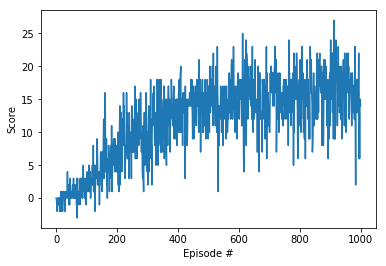

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, 
              double=False, dueling=False)

# Train the network
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

##### Vanilla DQN Notes: 

Good news.  Task solved.  The basic DQN model works.

### b) Double DQN

Episode 100	Average Score: -0.12	Latest Score: 0.00
Episode 200	Average Score: 3.25	Latest Score: 7.000
Episode 300	Average Score: 7.86	Latest Score: 11.00
Episode 400	Average Score: 9.36	Latest Score: 2.000
Episode 500	Average Score: 12.68	Latest Score: 13.00
Episode 530	Average Score: 13.00	Latest Score: 18.00
Environment solved in 430 episodes!	Average Score: 13.00
Episode 600	Average Score: 14.22	Latest Score: 11.00
Episode 700	Average Score: 14.92	Latest Score: 15.00
Episode 800	Average Score: 15.22	Latest Score: 19.00
Episode 900	Average Score: 14.73	Latest Score: 18.00
Episode 1000	Average Score: 15.36	Latest Score: 15.00


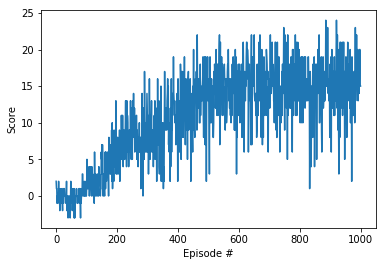

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, 
              double=True, dueling=False)

# Train the network
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

##### Double DQN Notes:

The Double DQN demonstrated somewhat better learning.



### c) Dueling DQN



Episode 100	Average Score: 0.85	Latest Score: -1.00
Episode 200	Average Score: 4.03	Latest Score: 4.000
Episode 300	Average Score: 7.72	Latest Score: 13.00
Episode 400	Average Score: 12.05	Latest Score: 13.00
Episode 441	Average Score: 13.02	Latest Score: 19.00
Environment solved in 341 episodes!	Average Score: 13.02
Episode 500	Average Score: 14.27	Latest Score: 16.00
Episode 600	Average Score: 14.74	Latest Score: 13.00
Episode 700	Average Score: 15.10	Latest Score: 17.00
Episode 800	Average Score: 14.62	Latest Score: 18.00
Episode 900	Average Score: 14.67	Latest Score: 17.00
Episode 1000	Average Score: 14.46	Latest Score: 24.00


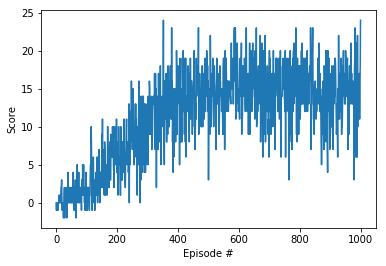

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, 
              double=False, dueling=True)

# Train the network
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

##### Dueling DQN Notes:

My Dueling DQN implementation seems to not have performed as well as expected (compared to Google Deep Mind paper) but does converge.  



### d) Combined Dueling Double DQN




Episode 100	Average Score: 0.42	Latest Score: 3.000
Episode 200	Average Score: 4.03	Latest Score: 11.00
Episode 300	Average Score: 7.91	Latest Score: 7.000
Episode 400	Average Score: 9.88	Latest Score: 9.000
Episode 498	Average Score: 13.06	Latest Score: 22.00
Environment solved in 398 episodes!	Average Score: 13.06
Episode 500	Average Score: 13.07	Latest Score: 13.00
Episode 600	Average Score: 14.92	Latest Score: 15.00
Episode 700	Average Score: 14.82	Latest Score: 21.00
Episode 800	Average Score: 15.79	Latest Score: 14.00
Episode 900	Average Score: 15.42	Latest Score: 18.00
Episode 1000	Average Score: 15.63	Latest Score: 22.00


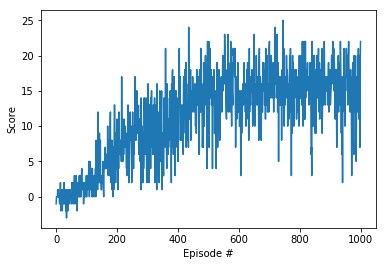

In [10]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, 
              double=True, dueling=True)

# Train the network
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

##### Combined Dueling Double DQN Notes:

Again, converges but without as much improvement compared to the Deep Mind paper.  I suspect my Dueling DQN implementation may need more work.  But assignment completed...

## Further work to be considered

If I had time (I don't!), I'd implement the remaining rainbow improvements described above and would figure out how to tweak my implementation of a dual network to make it work better.  I would also enjoy implementing a version of this algorithm that uses a deep convolutional network to learn from game screens (e.g., just as Deep Mind did in it's original papers).  

In addition, would be great to utilize my final weights (sans drop out, of course) to play the game.  It's very possible that my aggressive use of Drop Out, which reduces overfitting, may have subdued test results compared to if I implement best weights achieved (without Dropout) to play the game.